In [1]:
import pandas as pd
import numpy as np
import pickle, os, time
import itertools
from datetime import datetime, timedelta
from collections import Counter, defaultdict, namedtuple
from PIL import Image
import yaml
import pickle

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
data_dir = './data/'

In [4]:
# Load the population, labels, and baseline features
pop = pd.read_csv(data_dir + 'population/d10_with_vitals.csv').set_index('BMT_ID')

df_label_full = pop.join(pd.read_csv(data_dir + 'prep/label.csv', index_col='BMT_ID'), how='left')
df_static = pop.join(pd.read_csv(data_dir + 'features/static.csv', index_col='BMT_ID'), how='left')
df_static.index.rename('id', inplace=True)

df_label = df_label_full['Label_GVHD']
df_label34 = (df_label_full['GVHD_max_grade'] >= 3).astype(int)
assert not df_static[df_static.isnull().any(axis=1)].any().any()

# Load the vital sign time series
ts_vitals_by_bmt = pickle.load(open(data_dir + 'features/ts_vitals_by_bmt_2014_2017_MiChart.p', 'rb'))
ts_vitals_by_bmt = {ID: ts_vitals_by_bmt[ID] for ID in list(pop.index)}

In [5]:
# Select patients in the study population
ts_vitals_by_bmt = {k: v for k, v in ts_vitals_by_bmt.items() if k in pop.index.values}

In [6]:
print(len(ts_vitals_by_bmt))
sum(len(df) for df in ts_vitals_by_bmt.values())

324


99230

In [7]:
# New counts
df_count = pd.DataFrame()
for bmt_id in sorted(ts_vitals_by_bmt):
    df = ts_vitals_by_bmt[bmt_id].copy()
    df_ = df.set_index('t').stack().reset_index()
    df_['t_'] = np.floor(df_['t'])
    df_ = df_.groupby('t_')[['t']].count().reindex(range(0,20), fill_value=0).rename(columns={'t': bmt_id}).T
    df_count = df_count.append(df_)

df_count.columns = df_count.columns

In [8]:
len(df_count)

324

In [9]:
df_count.head()

t_,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
201406001,90,36,38,43,46,42,55,84,37,54,90,42,52,30,91,36,17,0,0,0
201406002,59,39,35,30,54,36,48,36,29,67,43,44,60,40,36,35,35,36,37,30
201406003,75,86,38,42,35,36,36,36,101,37,36,31,42,18,0,12,0,0,0,0
201406004,79,41,50,39,42,36,46,51,54,53,36,60,28,42,30,29,12,0,0,0
201406005,66,36,95,30,45,48,34,68,43,86,44,37,36,23,12,6,11,0,0,0


In [10]:
df_count.describe()

t_,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000,324.000000
mean,78.188272,46.734568,44.435185,43.537037,45.320988,47.688272,49.058642,54.743827,54.151235,59.694444,56.888889,54.953704,54.123457,49.398148,43.364198,36.077160,30.913580,28.268519,26.672840,24.206790
std,25.378589,18.425750,18.211659,16.759689,19.539958,23.065764,23.000733,24.725849,24.709181,25.607586,23.722206,22.684831,24.029204,25.318017,29.849313,29.374231,29.919478,33.182283,32.939729,33.967529
min,41.000000,24.000000,25.000000,21.000000,24.000000,24.000000,25.000000,28.000000,29.000000,26.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,63.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,40.000000,38.000000,37.000000,37.000000,36.000000,30.000000,12.000000,0.000000,0.000000,0.000000,0.000000
50%,72.000000,40.000000,38.000000,37.000000,38.000000,39.000000,41.000000,45.000000,48.000000,54.000000,49.000000,49.500000,47.000000,42.000000,38.000000,36.000000,33.000000,24.000000,15.000000,11.500000
75%,87.250000,49.000000,45.000000,46.000000,47.000000,52.000000,54.250000,65.000000,62.000000,70.000000,69.000000,62.000000,62.000000,58.000000,51.000000,50.000000,45.250000,42.000000,42.250000,37.250000
max,323.000000,161.000000,229.000000,147.000000,196.000000,294.000000,259.000000,150.000000,225.000000,215.000000,184.000000,173.000000,189.000000,154.000000,185.000000,226.000000,238.000000,262.000000,208.000000,209.000000


In [11]:
df_count.describe().loc['mean', 0]

78.18827160493827

In [12]:
(df_count.describe().loc['mean', 0:10].mean(),
df_count.describe().loc['mean', 10:20].mean())

(52.76739618406285, 40.48672839506173)

In [13]:
df_count

t_,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
201406001,90,36,38,43,46,42,55,84,37,54,90,42,52,30,91,36,17,0,0,0
201406002,59,39,35,30,54,36,48,36,29,67,43,44,60,40,36,35,35,36,37,30
201406003,75,86,38,42,35,36,36,36,101,37,36,31,42,18,0,12,0,0,0,0
201406004,79,41,50,39,42,36,46,51,54,53,36,60,28,42,30,29,12,0,0,0
201406005,66,36,95,30,45,48,34,68,43,86,44,37,36,23,12,6,11,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201711009,73,41,52,44,48,38,50,44,46,54,67,48,75,58,51,46,45,54,46,26
201712001,90,66,67,64,50,70,44,45,110,76,36,61,62,48,43,87,43,0,14,0
201712003,68,86,47,45,71,81,77,106,103,58,77,53,50,42,44,51,74,131,133,128
201712004,79,42,54,49,58,67,31,63,38,114,82,88,31,52,65,52,43,36,43,25


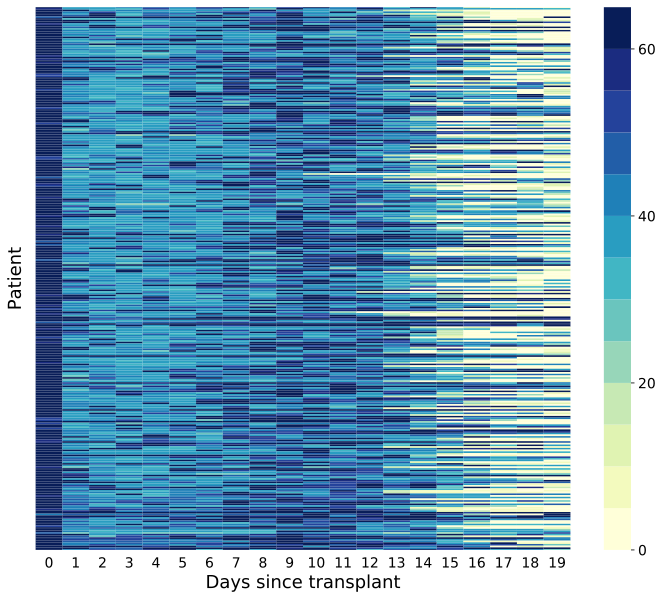

In [14]:
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(
    df_count, vmax=65, cmap=plt.cm.get_cmap('YlGnBu', 13), #'YlGnBu', 
    cbar_kws=dict(
        ticks=np.arange(0, 65, 20), 
        use_gridspec=False, 
        location='right', 
    )
)

# change colorbar font size
ax.figure.axes[-1].xaxis.label.set_size(20)
ax.figure.axes[-1].xaxis.labelpad = 10
ax.figure.axes[-1].tick_params(labelsize=14)

ax.set_yticklabels([])
ax.yaxis.label.set_size(18)
ax.xaxis.label.set_size(18)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(14)

for tick in ax.figure.axes[-1].yaxis.get_major_ticks():
    tick.label.set_fontsize(14)

plt.xlabel('Days since transplant')
plt.ylabel('Patient')
plt.savefig('fig/Vitals_heatmap.pdf', bbox_inches='tight')